<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter06/Road_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the impact of data augmentation and batch normalization
we will learn about how the usage of data augmentation can help in improving the accuracy of a model. Furthermore, we will learn about how data augmentation can practically be a pseudo-regularizer for our models.  

To understand the impact of data augmentation and batch normalization, we will go through a dataset of recognizing traffic signs. We will evaluate three scenarios:  
- No batch normalization/data augmentation
- Only batch normalization, but no data augmentation
- Both batch normalization and data augmentation

Let's code up for road sign detection without data augmentation and batch normalization, as follows:

In [2]:
import os
dataset_path = os.path.expanduser('/home/guy/datasets/GTSRB_road_sign/')
if not os.path.exists(dataset_path):
#     !pip install -U -q torch_snippets
#     !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#     !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#     !unzip -qq GTSRB_Final_Training_Images.zip
#     !unzip -qq GTSRB_Final_Test_Images.zip
#     !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
#     !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip
    print(f'could not find dataset in {dataset_path}')    

## No batch normalization / data augmentation

2022-03-17 12:23:52.992 | INFO     | __main__:__init__:41 - 29406
2022-03-17 12:23:52.993 | INFO     | __main__:__init__:41 - 9803


EPOCH: 1.000	trn_loss: 2.240	trn_acc: 0.349	val_loss: 1.189	val_acc: 0.621	(13.05s - 508.83s remaining)
EPOCH: 2.000	trn_loss: 0.907	trn_acc: 0.703	val_loss: 0.746	val_acc: 0.752	(25.87s - 491.62s remaining)
EPOCH: 3.000	trn_loss: 0.632	trn_acc: 0.792	val_loss: 0.575	val_acc: 0.814	(38.69s - 477.18s remaining)
EPOCH: 4.000	trn_loss: 0.517	trn_acc: 0.831	val_loss: 0.483	val_acc: 0.843	(51.54s - 463.85s remaining)
EPOCH: 5.000	trn_loss: 0.444	trn_acc: 0.855	val_loss: 0.446	val_acc: 0.851	(64.42s - 450.93s remaining)
EPOCH: 6.000	trn_loss: 0.404	trn_acc: 0.866	val_loss: 0.410	val_acc: 0.868	(77.32s - 438.12s remaining)
EPOCH: 7.000	trn_loss: 0.367	trn_acc: 0.880	val_loss: 0.407	val_acc: 0.872	(90.22s - 425.31s remaining)
EPOCH: 8.000	trn_loss: 0.353	trn_acc: 0.885	val_loss: 0.355	val_acc: 0.884	(103.10s - 412.40s remaining)
EPOCH: 9.000	trn_loss: 0.333	trn_acc: 0.892	val_loss: 0.340	val_acc: 0.891	(115.91s - 399.25s remaining)
EPOCH: 10.000	trn_loss: 0.306	trn_acc: 0.900	val_loss: 0.373	v

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 94.62it/s]


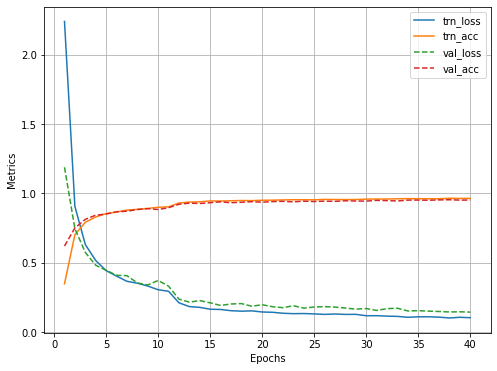

2022-03-17 12:32:32.239 | INFO     | __main__:<cell line: 146>:146 - Dumped object of size ≈2 MB @ "no-aug-no-bn.log" in 9.24e-01 seconds


In [3]:
from torch_snippets import *
classIds = pd.read_csv(os.path.join(dataset_path,'signnames.csv'))
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    #---------comment out data augmentation------
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    #---------------------------------------------
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob(dataset_path+'GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no),   # batchnorm commented out
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

## Only batch normalization, but no data augmentation

2022-03-17 12:43:19.506 | INFO     | __main__:__init__:39 - 29406
2022-03-17 12:43:19.507 | INFO     | __main__:__init__:39 - 9803


EPOCH: 1.000	trn_loss: 1.376	trn_acc: 0.589	val_loss: 0.559	val_acc: 0.818	(13.63s - 531.65s remaining)
EPOCH: 2.000	trn_loss: 0.437	trn_acc: 0.858	val_loss: 0.342	val_acc: 0.889	(27.24s - 517.50s remaining)
EPOCH: 3.000	trn_loss: 0.300	trn_acc: 0.902	val_loss: 0.307	val_acc: 0.898	(40.85s - 503.77s remaining)
EPOCH: 4.000	trn_loss: 0.242	trn_acc: 0.920	val_loss: 0.248	val_acc: 0.919	(54.47s - 490.25s remaining)
EPOCH: 5.000	trn_loss: 0.193	trn_acc: 0.936	val_loss: 0.209	val_acc: 0.931	(68.09s - 476.64s remaining)
EPOCH: 6.000	trn_loss: 0.172	trn_acc: 0.943	val_loss: 0.202	val_acc: 0.935	(81.65s - 462.71s remaining)
EPOCH: 7.000	trn_loss: 0.144	trn_acc: 0.952	val_loss: 0.185	val_acc: 0.942	(95.25s - 449.04s remaining)
EPOCH: 8.000	trn_loss: 0.142	trn_acc: 0.953	val_loss: 0.168	val_acc: 0.945	(108.88s - 435.50s remaining)
EPOCH: 9.000	trn_loss: 0.127	trn_acc: 0.960	val_loss: 0.139	val_acc: 0.954	(122.44s - 421.75s remaining)
EPOCH: 10.000	trn_loss: 0.127	trn_acc: 0.959	val_loss: 0.157	v

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 92.31it/s]


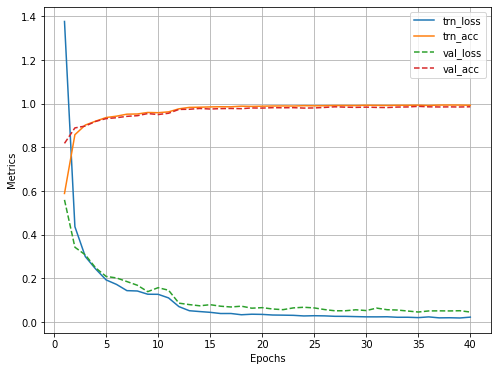

2022-03-17 12:52:25.572 | INFO     | __main__:<cell line: 144>:144 - Dumped object of size ≈2 MB @ "no-aug-yes-bn.log" in 9.16e-01 seconds


In [4]:
from torch_snippets import *
classIds = pd.read_csv(os.path.join(dataset_path,'signnames.csv'))
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob(dataset_path+'GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-yes-bn.log')

## Both batch normalization and data augmentation

2022-03-17 12:55:26.768 | INFO     | __main__:__init__:39 - 29406
2022-03-17 12:55:26.768 | INFO     | __main__:__init__:39 - 9803


EPOCH: 1.000	trn_loss: 1.826	trn_acc: 0.463	val_loss: 0.798	val_acc: 0.737	(24.67s - 962.21s remaining)
EPOCH: 2.000	trn_loss: 0.703	trn_acc: 0.771	val_loss: 0.496	val_acc: 0.838	(49.44s - 939.33s remaining)
EPOCH: 3.000	trn_loss: 0.505	trn_acc: 0.836	val_loss: 0.370	val_acc: 0.875	(74.20s - 915.13s remaining)
EPOCH: 4.000	trn_loss: 0.409	trn_acc: 0.866	val_loss: 0.327	val_acc: 0.887	(98.83s - 889.43s remaining)
EPOCH: 5.000	trn_loss: 0.341	trn_acc: 0.888	val_loss: 0.300	val_acc: 0.904	(123.55s - 864.87s remaining)
EPOCH: 6.000	trn_loss: 0.303	trn_acc: 0.899	val_loss: 0.243	val_acc: 0.919	(148.32s - 840.47s remaining)
EPOCH: 7.000	trn_loss: 0.276	trn_acc: 0.909	val_loss: 0.226	val_acc: 0.926	(173.07s - 815.89s remaining)
EPOCH: 8.000	trn_loss: 0.247	trn_acc: 0.919	val_loss: 0.204	val_acc: 0.929	(197.81s - 791.24s remaining)
EPOCH: 9.000	trn_loss: 0.238	trn_acc: 0.921	val_loss: 0.206	val_acc: 0.932	(222.56s - 766.58s remaining)
EPOCH: 10.000	trn_loss: 0.221	trn_acc: 0.926	val_loss: 0.17

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 90.04it/s]


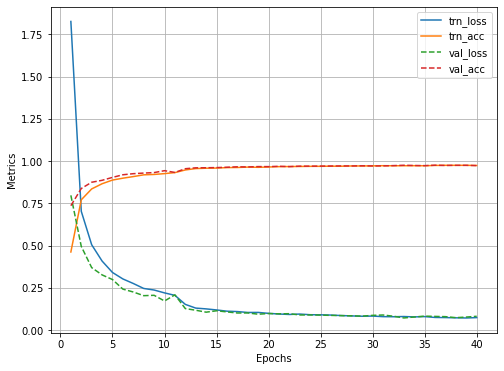

2022-03-17 13:11:58.469 | INFO     | __main__:<cell line: 144>:144 - Dumped object of size ≈2 MB @ "40-yes-aug-yes-bn.log" in 8.04e-01 seconds


ModuleNotFoundError: No module named 'google.colab'

In [5]:
from torch_snippets import *
classIds = pd.read_csv(os.path.join(dataset_path,'signnames.csv'))
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2), 
    contrast=(0.8,1.2), 
    saturation=(0.8,1.2), 
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob(dataset_path+'GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, '40-yes-aug-yes-bn.log')
# from google.colab import files
# files.download('40-yes-aug-yes-bn.log')

## Results


EPOCH: 20.000	trn_loss: 0.035	trn_acc: 0.988	val_loss: 0.066	val_acc: 0.980	(3725.45s - 3725.45s remaining)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 195.74it/s]


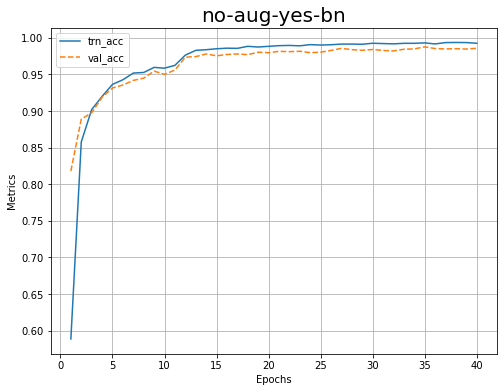



EPOCH: 20.000	trn_loss: 0.099	trn_acc: 0.965	val_loss: 0.098	val_acc: 0.968	(2999.18s - 2999.18s remaining)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 198.97it/s]


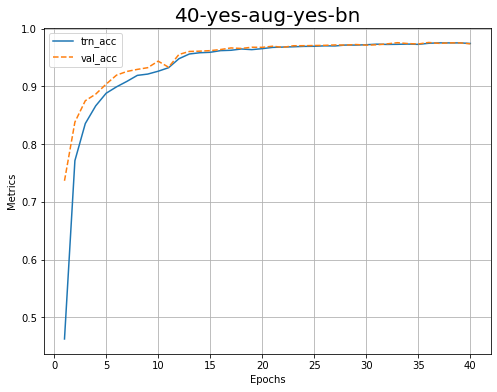



EPOCH: 20.000	trn_loss: 0.146	trn_acc: 0.951	val_loss: 0.198	val_acc: 0.937	(4892.27s - 4892.27s remaining)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 198.47it/s]


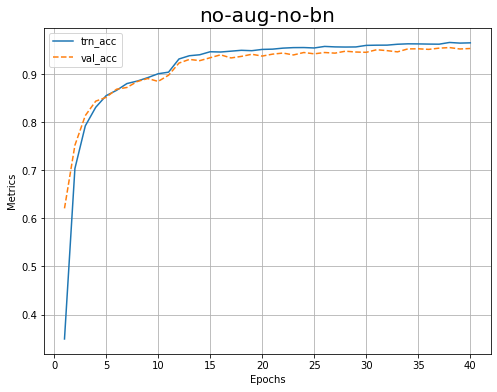

In [17]:
for f in Glob('*.log'):
    log = loaddill(f)
    print()
    log.report_avgs(20)
    log.plot_epochs(['trn_acc', 'val_acc'], title=str(f).replace('.log',''))
    print()
    line()